# Run the network with specific weight parameters

In [294]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [295]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.generateFrames as gf
#import cbgt.analyzefx as afx
#from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

# Specific for the HDDM study
#import hddm

# Save/load datatables functions

In [296]:
# directory = the filepath to where you want to save your data.  
#   You could use directory="" to save it in the same directory 
#   you are running the notebook in.

# foldername = a name for a new folder to put this specific data set in.
#   The code will create this folder for you.  
#   Whenever you have a new data set, you need to use a new foldername, 
#   otherwise it will overwrite the older results.

def saveData(paramtable,datatables,directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable.to_pickle(file_name,protocol=0)
    for i in range(len(datatables)):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables[i].to_pickle(file_name,protocol=0)
        
def loadData(directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable = pd.read_pickle(file_name)
    filecount = len([f for f in os.listdir(targetfolder) 
                     if os.path.isfile(os.path.join(targetfolder, f)) 
                     and f.startswith("data") and f.endswith(".pkl")])
    datatables = []
    for i in range(filecount):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables.append(pd.read_pickle(file_name))
    return (paramtable,datatables)

# Global Parameters:

In [297]:
# Working directory
parentDir = 'dftest'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

In [298]:
BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [299]:
def get_sampling_params2(scale=.05, values=[0.063,0.063,0.063,0.063,
                                          0.1286,0.1286,0.1286,0.1286,
                                          0.28,1.1,0.28,1.65,0.4,0.012,
                                          0.0324,0.067,0.255,0.255,
                                          0.03,0.132,0.07,4.01,0.02,1.5]):
    
    Cx_dMSN_NMDA_L = values[0] #0.063
    Cx_dMSN_NMDA_R = values[1] #0.063
    Cx_iMSN_NMDA_L = values[2] #0.063
    Cx_iMSN_NMDA_R = values[3] #0.063
    
    Cx_dMSN_AMPA_L = values[4] #0.1286
    Cx_dMSN_AMPA_R = values[5] #0.1286
    Cx_iMSN_AMPA_L = values[6] #0.1286
    Cx_iMSN_AMPA_R = values[7] #0.1286
    
    dMSN_iMSN = values[8] #0.28
    D1STR_GPi = values[9] #1.10
    
    iMSN_dMSN  = values[10] #0.28
    D2STR_GPeP = values[11] #1.65
    
    GPe_STN = values[12] #0.4
    GPe_GPi = values[13] #0.012
    
    STN_GPi    = values[14] #0.0324
    
    GPi_Th     =  values[15] #0.067
    
    Th_STRd = values[16] #0.255
    Th_STRi = values[17] #0.255
    
    
    
    CxTh       =    values[18] #0.03
    CxFSI      =    values[19] #0.132
    STN_GPeP_A =    values[20] #0.07
    STN_GPeP_N =    values[21] #4.01
    ThCx       =    values[22] #0.02
    
    GPeP_GPeP  =    values[23] #1.5 
    
    STN_GPeP = [STN_GPeP_A, STN_GPeP_N] # [AMPA, NMDA]
    
    CxSTRd = (Cx_dMSN_NMDA_L+Cx_dMSN_NMDA_R)/2.0
    CxSTRi = (Cx_iMSN_NMDA_L+Cx_iMSN_NMDA_R)/2.0
    
    preset = ng.set_post_learning_weights(dMSN=[Cx_dMSN_NMDA_L/CxSTRd, Cx_dMSN_NMDA_R/CxSTRd],
                                          iMSN=[Cx_iMSN_NMDA_L/CxSTRi, Cx_iMSN_NMDA_R/CxSTRi])
    
    preset[0]['D1STR_0_0'] = {'dpmn_w':Cx_dMSN_AMPA_L}
    preset[0]['D1STR_1_0'] = {'dpmn_w':Cx_dMSN_AMPA_R}
    preset[0]['D2STR_0_0'] = {'dpmn_w':Cx_iMSN_AMPA_L}
    preset[0]['D2STR_1_0'] = {'dpmn_w':Cx_iMSN_AMPA_R}
    
    #print(preset)

    
    mu = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi, 'GPeP': STN_GPeP},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi, 'GPeP': GPeP_GPeP})

    # PROVISIONAL
    sd = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi, 'GPeP': STN_GPeP},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi, 'GPeP': GPeP_GPeP})
    
    for x in list(sd):
        for y in sd[x]:
            sd[x][y]=0
    sd['STN']['GPeP']=[0,0]
    
    #sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd, preset

In [300]:
def get_sampling_params(scale=.05, values=[0.063,0.063,0.063,0.063,
                                          0.1286,0.1286,0.1286,0.1286,
                                          0.28,1.1,0.28,1.65,0.4,0.012,
                                          0.0324,0.067,0.255,0.255,
                                          0.03,0.132,0.07,4.01,0.02,1.5]):
    
    Cx_dMSN_NMDA_L = values[0,0] #0.063
    Cx_dMSN_NMDA_R = values[0,1] #0.063
    Cx_iMSN_NMDA_L = values[0,2] #0.063
    Cx_iMSN_NMDA_R = values[0,3] #0.063
    
    Cx_dMSN_AMPA_L = values[0,4] #0.1286
    Cx_dMSN_AMPA_R = values[0,5] #0.1286
    Cx_iMSN_AMPA_L = values[0,6] #0.1286
    Cx_iMSN_AMPA_R = values[0,7] #0.1286
    
    dMSN_iMSN = values[0,8] #0.28
    D1STR_GPi = values[0,9] #1.10
    
    iMSN_dMSN  = values[0,10] #0.28
    D2STR_GPeP = values[0,11] #1.65
    
    GPe_STN = values[0,12] #0.4
    GPe_GPi = values[0,13] #0.012
    
    STN_GPi    = values[0,14] #0.0324
    
    GPi_Th     =  values[0,15] #0.067
    
    Th_STRd = values[0,16] #0.255
    Th_STRi = values[0,17] #0.255
    
    
    
    CxTh       =    values[0,18] #0.03
    CxFSI      =    values[0,19] #0.132
    STN_GPeP_A =    values[0,20] #0.07
    STN_GPeP_N =    values[0,21] #4.01
    ThCx       =    values[0,22] #0.02
    
    GPeP_GPeP  =    values[0,23] #1.5 
        
    STN_GPeP = [STN_GPeP_A, STN_GPeP_N] # [AMPA, NMDA]
    
    CxSTRd = (Cx_dMSN_NMDA_L+Cx_dMSN_NMDA_R)/2.0
    CxSTRi = (Cx_iMSN_NMDA_L+Cx_iMSN_NMDA_R)/2.0
    
    preset = ng.set_post_learning_weights(dMSN=[Cx_dMSN_NMDA_L/CxSTRd, Cx_dMSN_NMDA_R/CxSTRd],
                                          iMSN=[Cx_iMSN_NMDA_L/CxSTRi, Cx_iMSN_NMDA_R/CxSTRi])
    
    preset[0]['D1STR_0_0'] = {'dpmn_w':Cx_dMSN_AMPA_L}
    preset[0]['D1STR_1_0'] = {'dpmn_w':Cx_dMSN_AMPA_R}
    preset[0]['D2STR_0_0'] = {'dpmn_w':Cx_iMSN_AMPA_L}
    preset[0]['D2STR_1_0'] = {'dpmn_w':Cx_iMSN_AMPA_R}
    
    #print(preset)

    mu = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi, 'GPeP': STN_GPeP},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi, 'GPeP':GPeP_GPeP})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd, preset


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    X['STN']['GPeP']=np.array(muEff['STN']['GPeP'])
    return X


def build_single_network(X, idx=0):
    
    Cx={'STRd': X['Cx']['STRd'][idx], 
        'STRi': X['Cx']['STRi'][idx],
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx],
           'D2STR': X['D1STR']['D2STR'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx],
           'D1STR_syn': X['D2STR']['D1STR_syn'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx],
        'GPeP': [X['STN']['GPeP'][0],X['STN']['GPeP'][1]]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STRd': X['Th']['STRd'][idx], 
        'STRi': X['Th']['STRi'][idx],
        'Cx': X['Th']['Cx'][idx]}
    
    GPeP={'STN': X['GPeP']['STN'][idx],
          'GPi': X['GPeP']['GPi'][idx],
          'GPeP': X['GPeP']['GPeP'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th, GPeP=GPeP)

# Phentotype - choose network values

In [338]:
import statistics
NumSteps=1  #number of steps
eps=1e-3    #discretization size

N_subj = 1
sdScale = .0 # variablity on the efficacy values.
conProb = ng.getConProb()

cores=4
np.random.seed(seed=np.random.randint(0,1000))

# set stimulus strength
stim = 2.5

# number of simulation we would like to run
totalSim = 1 #250

for ns in range(0,NumSteps):
    value=1.5 
    values=[0.018,0.018,0.018,0.018,
            0.0986,0.0986,0.0986,0.0986,
            0.28,1.1,0.28,1.65,0.35,0.018,0.0114,0.117,
            0.255,0.255,0.03,0.132,0.07,1.51,0.03,1.75]

    varIter=75
    print('Step',ns,' with value', value)
    
    # define parameters
    muEff, sdEff, preset = get_sampling_params2(sdScale,values)
    X = sample_network_efficacies(muEff, sdEff, N=N_subj)
    subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
    
    # get conn. efficacies for 1st subject network (idx=0)
    idx = 0
    conEff_i = subj_eff_dicts[idx]

    # configure trial and network parameters
    sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,totalSim)),
                               d1aw=[0], # Changes the alpha_w for D1
                               d2aw=[0], # Changes the alpha_w for D2
                               rewardprob=[1.0], # It's overwritten inside the netgen.
                               dpmn_ratio=0.,   # it doesn't do anything
                               dpmn_implied=0.,  # it doesn't do anything
                               SustainedFraction = 0.75
                              )
    sweepcount
    
    # run the simulation
    ng.compileAndRunSweepALL_Onofre(1,0,sweepcount,cores)
    
    results = ng.readAllTrialResults(1,0,totalSim,['popfreqs'])
    decisions = []
    for sn in range(totalSim):
        decisions.append([])
        for result in results[sn]:
            decisions[sn].append(ng.findOutputs2(result)['decision made'])
                
    # Change the None values in decisions' list for 0's
    for xdec in decisions[0][0]:
        if xdec['delay']==None:
            xdec['delay']=0.0
    
    (paramtable,datatables) = gf.generateFrames(results,decisions)
#    foldername="Prova"
#    saveData(paramtable,datatables,"",foldername)
    
    d1=datatables[0].decision[0:50]
    # REMOVE 'None' values from d
    d=[]
    for val in d1: 
        if val != None: 
            d.append(val) 
    dratio=(sum(d)/len(d))*100  # d contains 0=action is given; 1=action is NON given

          

Step 0  with value 1.5
Waiting for subprocess to end
Done


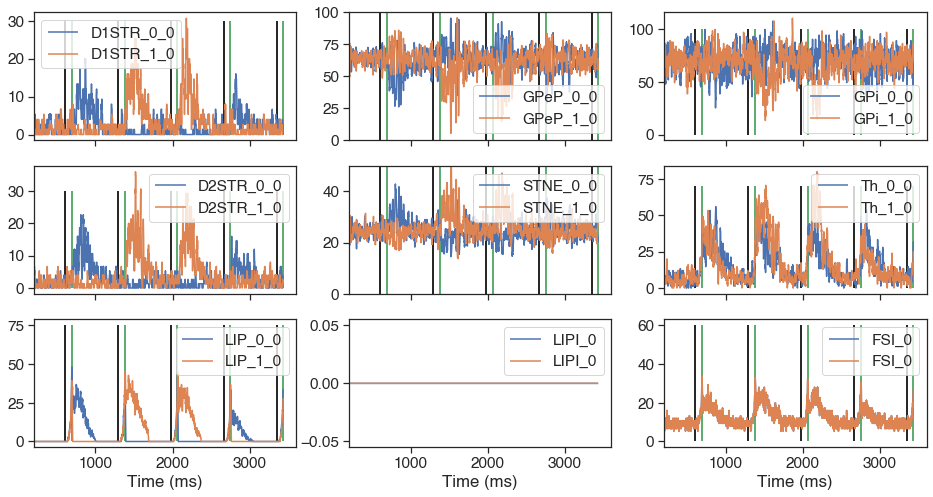

In [340]:
# Plot Population firing rates
results = ng.readAllTrialResults(8,0,sweepcount,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs'])
result = results[0][0]

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)
for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0',ax=ax1[0])
    ax1[0].vlines(datatables[0].stimulusstarttime,0,30,'k')
    ax1[0].vlines(datatables[0].decisiontime,0,30,'g')
    # ax1[0].vlines(datatables[0].rewardtime,0,30,'r')

    result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax1[1])
    ax1[1].vlines(datatables[0].stimulusstarttime,0,100,'k')
    ax1[1].vlines(datatables[0].decisiontime,0,100,'g')
    # ax1[1].vlines(datatables[0].rewardtime,0,100,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='GPi_'+str(i)+'_0', ax=ax1[2])
    ax1[2].vlines(datatables[0].stimulusstarttime,0,100,'k')
    ax1[2].vlines(datatables[0].decisiontime,0,100,'g')
    # ax1[2].vlines(datatables[0].rewardtime,0,100,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2[0])
    ax2[0].vlines(datatables[0].stimulusstarttime,0,30,'k')
    ax2[0].vlines(datatables[0].decisiontime,0,30,'g')
    # ax2[0].vlines(datatables[0].rewardtime,0,30,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax2[1])
    ax2[1].vlines(datatables[0].stimulusstarttime,0,50,'k')
    ax2[1].vlines(datatables[0].decisiontime,0,50,'g')
    # ax2[1].vlines(datatables[0].rewardtime,0,50,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax2[2])
    ax2[2].vlines(datatables[0].stimulusstarttime,0,70,'k')
    ax2[2].vlines(datatables[0].decisiontime,0,70,'g')
    # ax2[2].vlines(datatables[0].rewardtime,0,70,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='LIP_'+str(i)+'_0', ax=ax3[0])
    ax3[0].vlines(datatables[0].stimulusstarttime,0,75,'k')
    ax3[0].vlines(datatables[0].decisiontime,0,75,'g')
    # ax3[0].vlines(datatables[0].rewardtime,0,75,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='LIPI_0', ax=ax3[1])
    
    result['popfreqs'].plot(x='Time (ms)', y='FSI'+'_0', ax=ax3[2])
    ax3[2].vlines(datatables[0].stimulusstarttime,0,60,'k')
    ax3[2].vlines(datatables[0].decisiontime,0,60,'g')
    # ax3[2].vlines(datatables[0].rewardtime,0,60,'r')

for ax, axx, axxx in zip(ax1, ax2, ax3):
    ax.set_xlim(200, ax.get_xlim()[-1])#(750,900)#
    axx.set_xlim(200, axx.get_xlim()[-1])#(750,900)#
    axxx.set_xlim(200, axxx.get_xlim()[-1])#(750,900)#

#    ax.set_xlim(1200,2000)
#    axx.set_xlim(1200,2000)#
#    axxx.set_xlim(1200,2000)#



ax2[1].set_ylim(0,50)
ax1[1].set_ylim(0,100)
#ax3[0].set_ylim(0,5)


plt.savefig('ActualFR_1.png', dpi=400)

In [303]:
datatables[0].stimulusstarttime

trial
0     600.000000
1    1292.023804
2    1965.960571
3    2644.794800
4    3327.628174
Name: stimulusstarttime, dtype: float64

In [345]:
print('Th =',sum(result['popfreqs'].Th_0_0[100:600])/500.0)
print('GPe =',sum(result['popfreqs'].GPeP_0_0[100:600])/500.0)
print('GPi =',sum(result['popfreqs'].GPi_0_0[100:600])/500.0)
print('dMSN =',sum(result['popfreqs'].D1STR_0_0[100:600])/500.0)
print('iMSN =',sum(result['popfreqs'].D2STR_0_0[100:600])/500.0)
print('STN =',sum(result['popfreqs'].STNE_0_0[100:600])/500.0)
print('FSI =',sum(result['popfreqs'].FSI_0[100:600])/500.0)

Th = 5.239999430076981
GPe = 66.33400942993164
GPi = 72.17328351593018
dMSN = 1.2799999351501465
iMSN = 1.4746660641138924
STN = 24.576576652526857
FSI = 9.047991936683655
